In [ ]:
### BEWARE:Tensorflow is stochastic - this means the model will not be replicated exactly. 
### Use GA_Load_Model for reproduction

#!pip install mlxtend

#!pip install h5py pyyaml

#!pip install tensorboard

#!pip install tensorflow

In [ ]:
#Load packages

%load_ext tensorboard

%matplotlib inline

In [ ]:
### Packages necessary for model construction 

import tensorflow as tf
import tensorflow.keras.callbacks
import datetime 
import statistics

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os 

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn

import pydot

In [ ]:
#Read the Data

UN_Data = pd.read_csv('GA_Query_CleanLIWC')

UN_Data

,Unnamed: 0,date,Class M,Class S,Class I,Class P,Class B,Policy Passed,Conflict Indicator,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,0,2012,1,0,0,0,0,0,1,20075.0,99.00,68.60,14.49,96.27,27.24,34.34,77.56,42.78,5.44,2.15,0.35,1.48,0.00,0.07,0.24,3.29,11.21,16.88,3.82,1.51,5.00,0.26,6.50,6.69,1.68,0.35,2.43,1.01,7.11,5.98,...,0.60,0.0,0.25,11.52,3.10,2.91,3.37,1.12,2.16,1.37,4.82,0.97,12.55,1.22,8.62,2.69,6.46,0.50,0.09,0.54,0.12,0.03,0.22,0.0,0.10,0.01,0.10,0.0,11.80,4.04,4.34,0.03,0.04,0.00,0.0,1.23,0.07,0.64,0.82,0.60
1,1,2012,0,0,3,0,0,0,0,822.0,99.00,74.84,17.74,41.15,20.05,26.64,72.38,43.19,5.23,2.92,1.46,1.09,0.24,0.00,0.12,2.31,12.77,16.55,5.35,1.70,2.19,0.36,10.71,2.43,1.09,0.73,5.72,1.46,1.70,1.22,...,0.00,0.0,0.12,8.64,2.31,1.09,4.38,1.09,0.49,1.95,6.08,1.70,12.90,1.34,7.54,4.26,5.84,0.12,0.12,0.00,0.00,0.00,0.36,0.0,0.36,0.00,0.00,0.0,23.60,11.56,3.04,1.70,0.00,0.00,0.0,0.85,0.49,0.12,4.38,1.46
2,2,2003,0,0,0,0,0,0,0,314.0,99.00,66.07,4.02,31.19,19.62,29.30,72.93,38.54,2.55,0.32,0.00,0.00,0.00,0.32,0.00,2.23,13.38,17.20,4.14,0.32,0.96,0.00,6.37,3.82,1.27,0.00,13.06,1.27,0.64,0.32,...,0.00,0.0,0.96,8.92,0.32,0.96,7.32,0.32,0.00,4.46,2.55,0.32,10.83,0.64,6.05,3.82,10.51,0.00,0.32,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,34.08,20.70,3.50,0.96,0.00,0.00,0.0,2.23,0.00,0.64,3.18,2.87
3,3,1995,0,0,0,0,0,1,1,17021.0,98.45,62.93,24.54,58.00,32.30,30.04,75.49,46.31,6.64,2.17,0.66,0.95,0.01,0.09,0.45,4.48,11.69,16.96,5.22,2.20,4.48,0.57,7.80,4.04,1.46,0.79,4.00,1.33,4.85,3.25,...,0.17,0.0,0.09,7.50,2.27,1.74,2.61,0.88,0.79,1.59,5.12,1.11,12.84,0.95,8.61,3.24,4.57,0.39,0.08,0.42,0.09,0.09,0.35,0.0,0.26,0.03,0.06,0.0,13.34,3.44,4.91,0.25,0.17,0.02,0.0,1.33,0.22,0.16,0.64,2.18
4,4,2007,0,0,0,0,0,0,0,9289.0,98.94,60.45,8.85,70.17,22.82,32.95,78.23,44.38,4.40,0.82,0.02,0.00,0.00,0.58,0.22,3.58,13.27,15.19,5.80,1.71,4.61,0.56,9.08,3.90,1.47,0.44,4.94,1.35,3.93,3.07,...,0.52,0.0,0.00,9.01,1.17,3.18,3.89,0.72,0.70,5.12,2.73,0.86,11.68,1.35,7.12,3.12,7.94,0.17,0.36,1.98,0.00,0.04,0.08,0.0,0.01,0.03,0.03,0.0,14.38,5.37,3.80,0.16,0.15,0.00,0.0,0.93,0.28,0.75,1.42,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10207,10207,2004,0,0,0,0,0,0,0,4059.0,98.95,58.85,3.46,71.55,23.46,31.44,75.41,45.31,4.73,0.74,0.00,0.00,0.00,0.62,0.12,3.99,12.59,16.38,6.16,1.58,4.07,1.01,9.04,4.09,1.21,0.64,5.15,1.13,4.51,3.40,...,0.64,0.0,0.02,7.71,1.43,1.90,3.45,0.49,1.03,4.88,2.76,0.49,9.83,0.64,6.01,3.13,6.43,0.10,0.05,2.12,0.00,0.07,0.05,0.0,0.00,0.00,0.02,0.0,14.46,5.57,3.72,0.15,0.12,0.00,0.0,1.18,0.00,0.76,1.72,1.23
10208,10208,1994,0,0,0,0,0,0,0,8210.0,99.00,56.93,10.94,62.72,25.42,30.78,77.17,45.35,4.31,0.57,0.06,0.00,0.00,0.30,0.21,3.74,13.01,17.15,5.57,1.49,4.71,0.35,7.94,3.67,1.80,0.88,5.31,1.32,3.02,2.46,...,0.24,0.0,0.13,7.10,0.71,2.02,3.25,0.94,0.55,4.95,2.36,0.82,12.30,0.94,7.00,4.26,8.36,0.22,0.06,3.74,0.07,0.05,0.12,0.0,0.01,0.00,0.11,0.0,12.63,4.53,3.58,0.12,0.22,0.00,0.0,1.06,0.02,0.29,1.05,1.75
10209,10209,2013,0,0,0,0,0,0,0,583.0,99.00,67.21,10.22,31.63,27.76,25.39,71.70,43.91,6.52,1.54,0.86,0.00,0.17,0.17,0.34,4.97,13.72,15.95,3.95,1.37,3.60,0.00,7.20,2.74,0.69,0.17,10.46,1.54,0.51,0.34,...,0.00,0.0,0.00,7.38,1.03,0.34,3.43,2.40,0.17,2.23,4.63,1.54,10.29,0.51,5.49,3.43,7.55,0.00,0.17,1.03,0.17,0.00,0.17,0.0,0.17,0.00,0.00,0.

In [ ]:
#Inspect and Clean the Data

UN_Data.head(5)

UN_Data.drop(['Unnamed: 0'], axis = 1, inplace= True)

UN_Data

,date,Class M,Class S,Class I,Class P,Class B,Policy Passed,Conflict Indicator,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,2012,1,0,0,0,0,0,1,20075.0,99.00,68.60,14.49,96.27,27.24,34.34,77.56,42.78,5.44,2.15,0.35,1.48,0.00,0.07,0.24,3.29,11.21,16.88,3.82,1.51,5.00,0.26,6.50,6.69,1.68,0.35,2.43,1.01,7.11,5.98,1.11,...,0.60,0.0,0.25,11.52,3.10,2.91,3.37,1.12,2.16,1.37,4.82,0.97,12.55,1.22,8.62,2.69,6.46,0.50,0.09,0.54,0.12,0.03,0.22,0.0,0.10,0.01,0.10,0.0,11.80,4.04,4.34,0.03,0.04,0.00,0.0,1.23,0.07,0.64,0.82,0.60
1,2012,0,0,3,0,0,0,0,822.0,99.00,74.84,17.74,41.15,20.05,26.64,72.38,43.19,5.23,2.92,1.46,1.09,0.24,0.00,0.12,2.31,12.77,16.55,5.35,1.70,2.19,0.36,10.71,2.43,1.09,0.73,5.72,1.46,1.70,1.22,0.36,...,0.00,0.0,0.12,8.64,2.31,1.09,4.38,1.09,0.49,1.95,6.08,1.70,12.90,1.34,7.54,4.26,5.84,0.12,0.12,0.00,0.00,0.00,0.36,0.0,0.36,0.00,0.00,0.0,23.60,11.56,3.04,1.70,0.00,0.00,0.0,0.85,0.49,0.12,4.38,1.46
2,2003,0,0,0,0,0,0,0,314.0,99.00,66.07,4.02,31.19,19.62,29.30,72.93,38.54,2.55,0.32,0.00,0.00,0.00,0.32,0.00,2.23,13.38,17.20,4.14,0.32,0.96,0.00,6.37,3.82,1.27,0.00,13.06,1.27,0.64,0.32,0.00,...,0.00,0.0,0.96,8.92,0.32,0.96,7.32,0.32,0.00,4.46,2.55,0.32,10.83,0.64,6.05,3.82,10.51,0.00,0.32,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,34.08,20.70,3.50,0.96,0.00,0.00,0.0,2.23,0.00,0.64,3.18,2.87
3,1995,0,0,0,0,0,1,1,17021.0,98.45,62.93,24.54,58.00,32.30,30.04,75.49,46.31,6.64,2.17,0.66,0.95,0.01,0.09,0.45,4.48,11.69,16.96,5.22,2.20,4.48,0.57,7.80,4.04,1.46,0.79,4.00,1.33,4.85,3.25,1.55,...,0.17,0.0,0.09,7.50,2.27,1.74,2.61,0.88,0.79,1.59,5.12,1.11,12.84,0.95,8.61,3.24,4.57,0.39,0.08,0.42,0.09,0.09,0.35,0.0,0.26,0.03,0.06,0.0,13.34,3.44,4.91,0.25,0.17,0.02,0.0,1.33,0.22,0.16,0.64,2.18
4,2007,0,0,0,0,0,0,0,9289.0,98.94,60.45,8.85,70.17,22.82,32.95,78.23,44.38,4.40,0.82,0.02,0.00,0.00,0.58,0.22,3.58,13.27,15.19,5.80,1.71,4.61,0.56,9.08,3.90,1.47,0.44,4.94,1.35,3.93,3.07,0.71,...,0.52,0.0,0.00,9.01,1.17,3.18,3.89,0.72,0.70,5.12,2.73,0.86,11.68,1.35,7.12,3.12,7.94,0.17,0.36,1.98,0.00,0.04,0.08,0.0,0.01,0.03,0.03,0.0,14.38,5.37,3.80,0.16,0.15,0.00,0.0,0.93,0.28,0.75,1.42,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10207,2004,0,0,0,0,0,0,0,4059.0,98.95,58.85,3.46,71.55,23.46,31.44,75.41,45.31,4.73,0.74,0.00,0.00,0.00,0.62,0.12,3.99,12.59,16.38,6.16,1.58,4.07,1.01,9.04,4.09,1.21,0.64,5.15,1.13,4.51,3.40,0.96,...,0.64,0.0,0.02,7.71,1.43,1.90,3.45,0.49,1.03,4.88,2.76,0.49,9.83,0.64,6.01,3.13,6.43,0.10,0.05,2.12,0.00,0.07,0.05,0.0,0.00,0.00,0.02,0.0,14.46,5.57,3.72,0.15,0.12,0.00,0.0,1.18,0.00,0.76,1.72,1.23
10208,1994,0,0,0,0,0,0,0,8210.0,99.00,56.93,10.94,62.72,25.42,30.78,77.17,45.35,4.31,0.57,0.06,0.00,0.00,0.30,0.21,3.74,13.01,17.15,5.57,1.49,4.71,0.35,7.94,3.67,1.80,0.88,5.31,1.32,3.02,2.46,0.51,...,0.24,0.0,0.13,7.10,0.71,2.02,3.25,0.94,0.55,4.95,2.36,0.82,12.30,0.94,7.00,4.26,8.36,0.22,0.06,3.74,0.07,0.05,0.12,0.0,0.01,0.00,0.11,0.0,12.63,4.53,3.58,0.12,0.22,0.00,0.0,1.06,0.02,0.29,1.05,1.75
10209,2013,0,0,0,0,0,0,0,583.0,99.00,67.21,10.22,31.63,27.76,25.39,71.70,43.91,6.52,1.54,0.86,0.00,0.17,0.17,0.34,4.97,13.72,15.95,3.95,1.37,3.60,0.00,7.20,2.74,0.69,0.17,10.46,1.54,0.51,0.34,0.00,...,0.00,0.0,0.00,7.38,1.03,0.34,3.43,2.40,0.17,2.23,4.63,1.54,10.29,0.51,5.49,3.43,7.55,0.00,0.17,1.03,0.17,0.00,0.17,0.0,0.17,0.00

In [ ]:
#Inspect the data by key descriptive statistics

UN_Data.describe()

,date,Class M,Class S,Class I,Class P,Class B,Policy Passed,Conflict Indicator,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
count,10212.000000,10212.000000,10212.000000,10212.000000,10212.000000,10212.000000,10212.00000,10212.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,...,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000
mean,2005.852135,0.032805,0.009205,0.168625,0.051900,0.021641,0.13964,0.457697,9442.204220,98.190282,66.875703,12.898395,56.709126,25.304285,32.377559,74.262346,43.025112,5.245421,1.742787,0.269233,0.502975,0.028574,0.499537,0.442485,3.502526,10.834657,16.137896,5.045694,1.724823,4.734316,0.481271,8.091436,3.773042,1.521560,0.574251,4.922159,1.371374,4.117795,2.865873,1.176426,...,0.387821,0.057502,0.123219,8.555518,1.881719,1.977253,3.718665,0.936162,0.786315,3.606229,3.371183,0.627266,11.893252,1.004798,7.944224,2.889733,6.591531,0.289160,0.150839,1.037590,0.151080,0.091241,0.195391,0.001237,0.098407,0.024945,0.070841,0.000087,16.753078,5.740774,5.193233,0.303105,0.144628,0.031364,0.014043,1.154469,0.260464,0.397916,1.744508,1.768528
std,7.542111,0.229542,0.099521,0.861341,0.307019,0.156540,0.34663,0.498232,7786.325195,1.085791,6.906079,7.298162,18.251199,11.234321,4.117168,7.467984,5.098223,1.688333,1.063348,0.414985,0.757474,0.087247,0.419017,0.233972,0.874889,1.535397,1.917897,1.070806,0.565009,1.088154,0.249289,1.463034,0.816011,0.440595,0.251958,3.102461,0.412431,1.603232,1.095339,0.849716,...,0.528318,0.273305,0.185681,2.023621,1.005218,0.811497,1.141328,0.374087,0.474275,1.683420,1.691763,0.418849,2.030896,0.389119,1.632927,0.833989,2.061655,0.225462,0.138124,1.012639,0.200418,0.143312,0.164434,0.005468,0.147668,0.030712,0.051828,0.001865,8.792071,2.753868,3.290078,0.466117,0.190811,0.105541,0.713727,0.643019,0.439789,1.273977,1.466890,4.337472
min,1993.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,44.000000,80.460000,27.030000,1.000000,1.070000,3.650000,0.000000,0.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.160000,0.000000,0.210000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.130000,0.010000
25%,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3838.500000,97.880000,62.192500,7.172500,43.650000,22.610000,30.550000,73.130000,41.420000,4.0

In [ ]:
#Normalize the data 

UN_Data1 = tf.keras.utils.normalize(UN_Data.drop(columns = ['Class I']))

UN_Data1["Class I"] = UN_Data['Class I']

UN_Data1.describe()

,date,Class M,Class S,Class P,Class B,Policy Passed,Conflict Indicator,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,...,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP,Class I
count,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,...,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,1.019000e+04,10190.000000,10190.000000,10190.000000,1.019000e+04,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,10190.000000,1.019000e+04,10212.000000
mean,0.345714,0.000004,0.000001,0.000007,0.000002,0.000020,0.000056,0.881989,0.016961,0.011428,0.001900,0.009263,0.004283,0.005549,0.012424,0.007155,0.000806,0.000245,0.000037,0.000044,0.000004,0.000093,0.000066,0.000561,0.001912,0.002711,0.000844,0.000256,0.000735,0.000073,0.001368,0.000615,0.000235,0.000086,0.001106,0.000223,0.000579,0.000413,0.000150,0.000032,...,0.000007,0.000019,0.001355,0.000264,0.000290,0.000651,0.000143,0.000107,0.000665,0.000493,0.000102,0.001978,0.000157,0.001291,0.000516,0.001211,0.000042,0.000025,0.000174,0.000021,0.000011,0.000032,1.666496e-07,0.000018,0.000003,0.000010,1.862753e-08,0.003400,0.001225,0.000867,0.000081,0.000027,0.000006,0.000003,0.000222,0.000051,0.000066,0.000417,4.345803e-04,0.168625
std,0.252698,0.000030,0.000017,0.000050,0.000021,0.000065,0.000086,0.193529,0.012448,0.008500,0.001883,0.006951,0.005428,0.004126,0.008650,0.004983,0.000577,0.000228,0.000098,0.000090,0.000019,0.000115,0.000061,0.000404,0.001528,0.001952,0.000626,0.000174,0.000457,0.000073,0.001017,0.000455,0.000167,0.000069,0.001544,0.000183,0.000352,0.000278,0.000131,0.000054,...,0.000034,0.000038,0.000910,0.000210,0.000215,0.000589,0.000112,0.000092,0.000570,0.000407,0.000133,0.001433,0.000126,0.000887,0.000494,0.001095,0.000049,0.000035,0.000243,0.000040,0.000029,0.000053,1.366956e-06,0.000048,0.000008,0.000014,6.284069e-07,0.004333,0.001652,0.000835,0.000179,0.000070,0.000029,0.000154,0.000308,0.000150,0.000281,0.000665,1.748792e-03,0.861341
min,0.026924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021901,0.001303,0.001053,0.000029,0.000095,0.000366,0.000000,0.000239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000170,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000003,4.473887e-07,0.000000
25%,0.159519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.885374,0.007792,0.005150,0.000878,0.004105,0.002035,0.002550,0.005943,0.003449,0.000402,0.00012

In [ ]:
#Divide our variables between the independent variables (features) and dependent variables (policy passage)

labels = UN_Data1 ['Class I']
features = UN_Data1.drop(columns= ['Policy Passed', 'date', 'Class M', 'Class S', 'Class I', 'Class P', 'Class B', 'Conflict Indicator'])

In [ ]:
#Drop Null Values

features = features.fillna(0)
labels = labels.fillna(0)

In [ ]:
#Inspect shape of features

features = pd.get_dummies(features)
features.shape[0:5]

(10212, 93)

In [ ]:
#Define type of feature and label values

features = features.values.astype('float32')
labels = labels.values.astype('float32')

In [ ]:
#Data Sets for Training

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, test_size=0.2)

In [ ]:
#Define Precision, Recall, and F1 score metrics
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

In [ ]:
#Create your model

model1 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)), keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'), keras.layers.Dense(2, activation='softmax')])
model2 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model3 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model4 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model5 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

model6 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model7 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model8 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model9 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model10 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

model11 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model12 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model13 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model14 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model15 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

model16 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model17 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model18 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model19 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model20 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

model21 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model22 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model23 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model24 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model25 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

model26 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model27 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model28 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model29 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])
model30 = tf.keras.Sequential([keras.layers.Dense(132, input_shape=(93,)),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.10),keras.layers.Dense(32, activation= 'relu'),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(2, activation='softmax')])

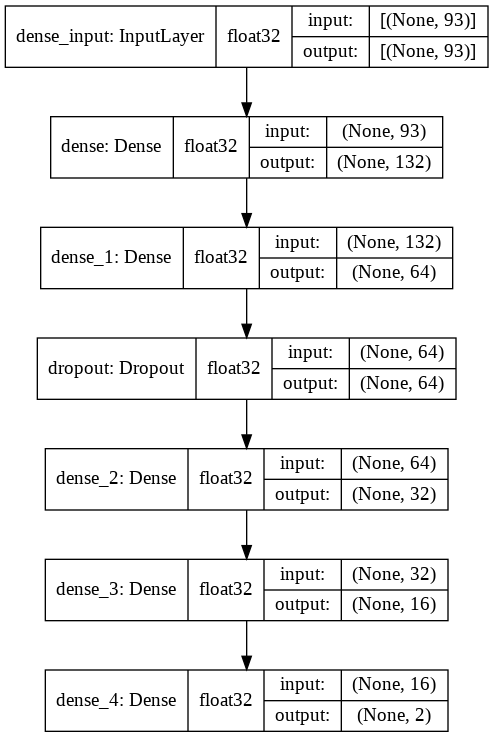

In [ ]:
### Inspect form of model

tf.keras.utils.plot_model(model1, to_file='model.png', show_shapes = True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Check Trainable Parameters
# Note: All the models are similarly structured

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 132)               12408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8512      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 23,562
Trainable params: 23,562
Non-trainable params: 0
____________________________________________________

In [ ]:
#Set checkpoints, metrics, loss, and optimizer functions for the model

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model1.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model2.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model3.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model4.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model5.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

model6.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model7.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model8.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model9.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model10.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

model11.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model12.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model13.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model14.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model15.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

model16.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model17.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model18.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model19.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model20.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

model21.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model22.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model23.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model24.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model25.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

model26.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model27.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model28.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model29.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])
model30.compile(optimizer='adam',loss='mse',metrics=['acc', precision, recall, f1_metric])

In [ ]:
#Run the model

print("Model 1 Fitting")
history1 = model1.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 2 Fitting")
history2 = model2.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 3 Fitting")
history3 = model3.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 4 Fitting")
history4 = model4.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 5 Fitting")
history5 = model5.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

print("Model 6 Fitting")
history6 = model6.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 7 Fitting")
history7 = model7.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 8 Fitting")
history8 = model8.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 9 Fitting")
history9 = model9.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 10 Fitting")
history10 = model10.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

print("Model 11 Fitting")
history11 = model11.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 12 Fitting")
history12 = model12.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 13 Fitting")
history13 = model13.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 14 Fitting")
history14 = model14.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 15 Fitting")
history15 = model15.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

print("Model 16 Fitting")
history16 = model16.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 17 Fitting")
history17 = model17.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 18 Fitting")
history18 = model18.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 19 Fitting")
history19 = model19.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 20 Fitting")
history20 = model20.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

print("Model 21 Fitting")
history21 = model21.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 22 Fitting")
history22 = model22.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 23 Fitting")
history23 = model23.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 24 Fitting")
history24 = model24.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 25 Fitting")
history25 = model25.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

print("Model 26 Fitting")
history26 = model26.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 27 Fitting")
history27 = model27.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 28 Fitting")
history28 = model28.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 29 Fitting")
history29 = model29.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])
print("Model 30 Fitting")
history30 = model30.fit(features_train, labels_train, epochs=50, validation_data=(features_validation, labels_validation), callbacks=[tensorboard_callback])

Model 1 Fitting
Epoch 1/50
205/205 [==============================] - 2s 5ms/step - loss: 0.8086 - acc: 0.4972 - precision: 0.1191 - recall: 1.2342 - f1_metric: 0.2132 - val_loss: 0.9305 - val_acc: 0.8874 - val_precision: 0.1316 - val_recall: 1.3040 - val_f1_metric: 0.2316
Epoch 2/50
205/205 [==============================] - 1s 3ms/step - loss: 0.8510 - acc: 0.5071 - precision: 0.1203 - recall: 1.2802 - f1_metric: 0.2156 - val_loss: 0.9305 - val_acc: 0.8917 - val_precision: 0.1317 - val_recall: 1.3040 - val_f1_metric: 0.2317
Epoch 3/50
205/205 [==============================] - 1s 3ms/step - loss: 0.6803 - acc: 0.4952 - precision: 0.1145 - recall: 1.2292 - f1_metric: 0.2056 - val_loss: 0.9305 - val_acc: 0.8140 - val_precision: 0.1316 - val_recall: 1.3040 - val_f1_metric: 0.2316
Epoch 4/50
205/205 [==============================] - 1s 3ms/step - loss: 0.7327 - acc: 0.4776 - precision: 0.1174 - recall: 1.2383 - f1_metric: 0.2103 - val_loss: 0.9305 - val_acc: 0.5991 - val_precision: 0.13

In [ ]:
#Run model predictions

# Model 1 
prediction_features_1 = model1.predict(features_test)
performance1 = model1.evaluate(features_test, labels_test)
print(performance1)
# Model 2 
prediction_features_2 = model2.predict(features_test)
performance2 = model2.evaluate(features_test, labels_test)
print(performance1)
# Model 3 
prediction_features_3 = model3.predict(features_test)
performance3 = model3.evaluate(features_test, labels_test)
print(performance1)
# Model 4 
prediction_features_4 = model4.predict(features_test)
performance4 = model4.evaluate(features_test, labels_test)
print(performance4)
# Model 5 
prediction_features_5 = model5.predict(features_test)
performance5 = model5.evaluate(features_test, labels_test)
print(performance5)

# Model 6 
prediction_features_6 = model6.predict(features_test)
performance6 = model6.evaluate(features_test, labels_test)
print(performance6)
# Model 7
prediction_features_7 = model7.predict(features_test)
performance7 = model7.evaluate(features_test, labels_test)
print(performance7)
# Model 8 
prediction_features_8 = model8.predict(features_test)
performance8 = model8.evaluate(features_test, labels_test)
print(performance8)
# Model 9
prediction_features_9 = model9.predict(features_test)
performance9 = model9.evaluate(features_test, labels_test)
print(performance9)
# Model 10
prediction_features_10 = model10.predict(features_test)
performance10 = model10.evaluate(features_test, labels_test)
print(performance10)

# Model 11 
prediction_features_11 = model11.predict(features_test)
performance11 = model11.evaluate(features_test, labels_test)
print(performance11)
# Model 12 
prediction_features_12 = model12.predict(features_test)
performance12 = model12.evaluate(features_test, labels_test)
print(performance12)
# Model 13 
prediction_features_13 = model13.predict(features_test)
performance13 = model13.evaluate(features_test, labels_test)
print(performance13)
# Model 14 
prediction_features_14 = model14.predict(features_test)
performance14 = model14.evaluate(features_test, labels_test)
print(performance14)
# Model 15 
prediction_features_15 = model15.predict(features_test)
performance15 = model15.evaluate(features_test, labels_test)
print(performance15)

# Model 16
prediction_features_16 = model16.predict(features_test)
performance16 = model16.evaluate(features_test, labels_test)
print(performance16)
# Model 17
prediction_features_17 = model17.predict(features_test)
performance17 = model17.evaluate(features_test, labels_test)
print(performance17)
# Model 18 
prediction_features_18 = model18.predict(features_test)
performance18 = model18.evaluate(features_test, labels_test)
print(performance18)
# Model 19
prediction_features_19 = model19.predict(features_test)
performance19 = model19.evaluate(features_test, labels_test)
print(performance19)
# Model 20 
prediction_features_20 = model20.predict(features_test)
performance20 = model20.evaluate(features_test, labels_test)
print(performance20)

# Model 21
prediction_features_21 = model21.predict(features_test)
performance21 = model21.evaluate(features_test, labels_test)
print(performance21)
# Model 22
prediction_features_22 = model22.predict(features_test)
performance22 = model22.evaluate(features_test, labels_test)
print(performance22)
# Model 23
prediction_features_23 = model23.predict(features_test)
performance23 = model23.evaluate(features_test, labels_test)
print(performance23)
# Model 24 
prediction_features_24 = model24.predict(features_test)
performance24 = model24.evaluate(features_test, labels_test)
print(performance24)
# Model 25
prediction_features_25 = model25.predict(features_test)
performance25 = model25.evaluate(features_test, labels_test)
print(performance25)

# Model 26 
prediction_features_26 = model26.predict(features_test)
performance26 = model26.evaluate(features_test, labels_test)
print(performance26)
# Model 27 
prediction_features_27 = model27.predict(features_test)
performance27 = model27.evaluate(features_test, labels_test)
print(performance27)
# Model 28 
prediction_features_28 = model28.predict(features_test)
performance28 = model28.evaluate(features_test, labels_test)
print(performance28)
# Model 29
prediction_features_29 = model29.predict(features_test)
performance29 = model29.evaluate(features_test, labels_test)
print(performance29)
# Model 30 
prediction_features_30 = model30.predict(features_test)
performance30 = model30.evaluate(features_test, labels_test)
print(performance30)

64/64 [==============================] - 0s 2ms/step - loss: 0.7365 - acc: 0.8982 - precision: 0.1153 - recall: 1.2522 - f1_metric: 0.2073
[0.7365394234657288, 0.8981889486312866, 0.11529270559549332, 1.252213716506958, 0.20732875168323517]
64/64 [==============================] - 0s 2ms/step - loss: 0.7365 - acc: 0.0622 - precision: 0.1152 - recall: 1.2522 - f1_metric: 0.2072
[0.7365394234657288, 0.8981889486312866, 0.11529270559549332, 1.252213716506958, 0.20732875168323517]
64/64 [==============================] - 0s 2ms/step - loss: 0.7365 - acc: 0.1043 - precision: 0.1160 - recall: 1.2522 - f1_metric: 0.2084
[0.7365394234657288, 0.8981889486312866, 0.11529270559549332, 1.252213716506958, 0.20732875168323517]
64/64 [==============================] - 0s 2ms/step - loss: 0.7365 - acc: 0.0627 - precision: 0.1152 - recall: 1.2522 - f1_metric: 0.2072
[0.7365394234657288, 0.06265296041965485, 0.11519820243120193, 1.252213716506958, 0.2071799486875534]
64/64 [=============================

In [ ]:
# Averages

# Loss
loss_avg = (performance1[0] + performance2[0] + performance3[0] + performance4[0] + performance5[0] + performance6[0] + performance7[0] + performance8[0] + performance9[0] + performance10[0]
            + performance11[0] + performance12[0] + performance13[0] + performance14[0] + performance15[0] + performance16[0] + performance17[0] + performance18[0] + performance19[0] + performance20[0]
            + performance21[0] + performance22[0] + performance23[0] + performance24[0] + performance25[0] + performance26[0] + performance27[0] + performance28[0] + performance29[0] + performance30[0])/30
print("Loss Average: ", loss_avg)

# Accuracy
acc_avg =(performance1[1] + performance2[1] + performance3[1] + performance4[1] + performance5[1] + performance6[1] + performance7[1] + performance8[1] + performance9[1] + performance10[1]
            + performance11[1] + performance12[1] + performance13[1] + performance14[1] + performance15[1] + performance16[1] + performance17[1] + performance18[1] + performance19[1] + performance20[1]
            + performance21[1] + performance22[1] + performance23[1] + performance24[1] + performance25[1] + performance26[1] + performance27[1] + performance28[1] + performance29[1] + performance30[1])/30
print("Accuraccy Average: ", acc_avg)

# Precision
precision_avg = (performance1[2] + performance2[2] + performance3[2] + performance4[2] + performance5[2] + performance6[2] + performance7[2] + performance8[2] + performance9[2] + performance10[2]
            + performance11[2] + performance12[2] + performance13[2] + performance14[2] + performance15[2] + performance16[2] + performance17[2] + performance18[2] + performance19[2] + performance20[2]
            + performance21[2] + performance22[2] + performance23[2] + performance24[2] + performance25[2] + performance26[2] + performance27[2] + performance28[2] + performance29[2] + performance30[2])/30
print("Precision Average: ", precision_avg)

# Recall
recall_avg = (performance1[3] + performance2[3] + performance3[3] + performance4[3] + performance5[3] + performance6[3] + performance7[3] + performance8[3] + performance9[3] + performance10[3]
            + performance11[3] + performance12[3] + performance13[3] + performance14[3] + performance15[3] + performance16[3] + performance17[3] + performance18[3] + performance19[3] + performance20[3]
            + performance21[3] + performance22[3] + performance23[3] + performance24[3] + performance25[3] + performance26[3] + performance27[3] + performance28[3] + performance29[3] + performance30[3])/30
print("Recall Average: ", recall_avg)

# f1_metric
f1_avg = (performance1[4] + performance2[4] + performance3[4] + performance4[4] + performance5[4] + performance6[4] + performance7[4] + performance8[4] + performance9[4] + performance10[4]
            + performance11[4] + performance12[4] + performance13[4] + performance14[4] + performance15[4] + performance16[4] + performance17[4] + performance18[4] + performance19[4] + performance20[4]
            + performance21[4] + performance22[4] + performance23[4] + performance24[4] + performance25[4] + performance26[4] + performance27[4] + performance28[4] + performance29[4] + performance30[4])/30
print("F1 Average: ", f1_avg)

Loss Average:  0.7365394234657288
Accuraccy Average:  0.4400065234551827
Precision Average:  0.11529946277538936
Recall Average:  1.252213716506958
F1 Average:  0.20734166006247204


In [ ]:
#Take the standard deviation of the model samples

#Loss SE
Loss_SE = statistics.stdev([performance1[0], performance2[0], performance3[0], performance4[0], performance5[0],
                  performance6[0], performance7[0], performance8[0], performance9[0], performance10[0],
                  performance11[0], performance12[0], performance13[0], performance14[0], performance15[0],
                  performance16[0], performance17[0], performance18[0], performance19[0], performance20[0], 
                  performance21[0], performance22[0], performance23[0], performance24[0], performance25[0],
                  performance26[0], performance27[0], performance28[0], performance29[0], performance30[0]])
print("Loss SE:", Loss_SE)

#Accuracy SE
Acc_SE = statistics.stdev([performance1[1], performance2[1], performance3[1], performance4[1], performance5[1],
                  performance6[1], performance7[1], performance8[1], performance9[1], performance10[1],
                  performance11[1], performance12[1], performance13[1], performance14[1], performance15[1],
                  performance16[1], performance17[1], performance18[1], performance19[1], performance20[1], 
                  performance21[1], performance22[1], performance23[1], performance24[1], performance25[1],
                  performance26[1], performance27[1], performance28[1], performance29[1], performance30[1]])
print("Accuraccy SE: ", Acc_SE)

#Precision SE
precision_SE = statistics.stdev([performance1[2], performance2[2], performance3[2], performance4[2], performance5[2],
                  performance6[2], performance7[2], performance8[2], performance9[2], performance10[2],
                  performance11[2], performance12[2], performance13[2], performance14[2], performance15[2],
                  performance16[2], performance17[2], performance18[2], performance19[2], performance20[2], 
                  performance21[2], performance22[2], performance23[2], performance24[2], performance25[2],
                  performance26[2], performance27[2], performance28[2], performance29[2], performance30[2]])
print("Precision SE: ", precision_SE)

#Recall 
Recall_SE = statistics.stdev([performance1[3], performance2[3], performance3[3], performance4[3], performance5[3],
                  performance6[3], performance7[3], performance8[3], performance9[3], performance10[3],
                  performance11[3], performance12[3], performance13[3], performance14[3], performance15[3],
                  performance16[3], performance17[3], performance18[3], performance19[3], performance20[3], 
                  performance21[3], performance22[3], performance23[3], performance24[3], performance25[3],
                  performance26[3], performance27[3], performance28[3], performance29[3], performance30[3]])
print("Recall SE: ", Recall_SE)

#F1 Score
F1_Score_SE = statistics.stdev([performance1[4], performance2[4], performance3[4], performance4[4], performance5[4],
                  performance6[4], performance7[4], performance8[4], performance9[4], performance10[4],
                  performance11[4], performance12[4], performance13[4], performance14[4], performance15[4],
                  performance16[4], performance17[4], performance18[4], performance19[4], performance20[4], 
                  performance21[4], performance22[4], performance23[4], performance24[4], performance25[4],
                  performance26[4], performance27[4], performance28[4], performance29[4], performance30[4]])
print("F1_Score_SE: ", F1_Score_SE)

Loss SE: 0.0
Accuraccy SE:  0.406947912130386
Precision SE:  0.00027242710848082203
Recall SE:  0.0
F1_Score_SE:  0.00043387163848523924


In [ ]:
#Tensorflow Graphics

%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>